### Purpose
The purpose of this code is to reproduce the response of a superconducting quantum interference device (SQUID) by numerical simulation, in the absence of noise. This is a numerical excercise on the road to developing a better physical model that includes noise. We will use a basic Runge-Kutta 4th order fixed-time step to simulate the average voltage response of a pair of resistively shunted Josephson junctions in parrallel, *without* Johnson noise in the shunt. We wish to make the model dependent on physical parameters of the circuit: critical current and symmetry constants in shunt resistance and branch inductances; and dependent on input parameters: applied flux and bias current. This model will be useful as a proof of concept and functional confirmation of the method chosen.
![qSUIDvsurf.jpg](qSQUIDvsurf.jpg)

### The Model
The model used here is from Tesche-Clarke 1977, section 2. The model is developed by combining the Josephson effects of two resistively shunted Josephson junctions arranged on a superconductiong ring. The junctions are in parrallel with respect to the bias current and voltage across the circuit.
![squid_circuit.jpg](squid_circuit.jpg)
Having combined effects and converte to dimensionless units, the description of the system is found to be:

$$j = (\delta_1 - \delta_2 - 2\pi\phi_a)/\pi \beta{}_L - \eta i /2$$

$$v = \frac{1+\eta}{2}\frac{d\delta_1}{d\theta} + \frac{1-\eta}{2}\frac{d\delta_2}{d\theta}$$

$$\frac{d\delta_1}{d\theta} = \frac{i/2 - j-(1-\alpha)\sin{\delta_1}}{1-\rho} + v_{N1}$$

$$\frac{d\delta_2}{d\theta} = \frac{i/2 - j-(1+\alpha)\sin{\delta_2}}{1+\rho} + v_{N2}$$

#### Parameters

$I_0$ - critical current of each junction

$\Phi_0$ - flux quantum

$R$ - total resistance of circuit (shunts)

$\theta$ - dimensionless time [$\Phi_0/2\pi I_0 R$]

$j$ - circulating current in superconducting ring [$I_0$]

$\delta_{1,2}$ - phase difference across each junction

$\phi_a$ - applied flux [$\Phi_0$]

$\eta$ - inductance symmetry parameter (0 to 1)

$v$ - voltage across circuit [$I_0 R$]

$i$ - applied bias current [$I_0$]

$\alpha$ - critical current symmetry parameter (0 to 1)

$\rho$ - resistance symmetry parameter (0 to 1)

$v_{N1,2}$ - noise signal, random Gaussian distributed voltage value [$I_0 R$]

This model does not consider Johnson noise in the resistive shunts. The noise voltages $v_{N1,2}$ will be left at zero, thus also making the model independent of the thermal noise parameter $\Gamma$, which is discussed in the noise model elsewhere.

In an RK4 scheme, the model is typically defined by a function which returns the n derivatives needed to described the behavior of the system. In this particular case, we have only the first derivatives in two parameters, which are non linear. Below is the function which takes the values $\delta_{1,2}$ and returns the time derivatives $\dot{\delta}_{1,2}$. The circulating current $j$ and the current acrross both junctions $i$ are calculated as intermediate steps.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import interpolate
import csv
import datetime

Immediately below is a simple function that draws a progress bar. Because these simulations are comprised of a series of simulations, and because we are employing a very simple but accurate numerical method, they can take some processing time.

In [4]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
def qSquidRK(s,th,param):
    
#    Returns RHS of RSJ ODE; used by rk4
# Inputs
#    s      -   State vector [del1(theta), del2(theta)]
#    theta  -   time
#    params -   [alpha, beta, eta, rho, i, phia]
# Ouputs
#    deriv  -   Derivaties [d1(theta), d2(theta)]

    alpha = param[0]; beta = param[1];
    eta = param[2]; rho = param[3]
    i = param[4]; phia = param[5]
    del1 = s[0] # del_1(theta)
    del2 = s[1] # del_2(theta)
    j = (del1 - del2 - 2*np.pi*phia)/(np.pi*beta)- eta*i/2
    
    d1 = (.5*i-j-(1-alpha)*np.sin(del1))/(1-rho)
    d2 = (.5*i+j-(1+alpha)*np.sin(del2))/(1+rho)
    
    deriv = np.array([d1,d2])
    return(deriv)

### Numerical Method
#### Modified Runge-Kutta 4th order, fixed-time step

$$x(t + \tau) = x(t) + \frac{1}{6}\tau(\boldsymbol{F}_1 + 2\boldsymbol{F}_2 + 2\boldsymbol{F}_3 +\boldsymbol{F}_4)$$

$$\boldsymbol{F}_1=f(x,t)$$
$$\boldsymbol{F}_2=f\bigg(x+\frac{1}{2}\tau\boldsymbol{F}_1, t + \frac{1}{2}\tau\bigg)$$
$$\boldsymbol{F}_3=f\bigg(x+\frac{1}{2}\tau\boldsymbol{F}_2, t +\frac{1}{2}\tau\bigg)$$
$$\boldsymbol{F}_4=f\bigg(x+\tau\boldsymbol{F}_3, t + \tau\bigg)$$

We will use a basic RK4 fixed-time step method to solve the time series voltage output for the system. The fixed step size is chosen to simplify the modification of the method to consider noise, $v_{N1,2}$ at a later time. The RK4 method will use half-time steps, meaning the method will calculate values at the current moment, halfway to the next time output, and at the next time point to output the value at the next time point.

In [6]:
def rk4(x,t,tau,derivsRK,param):
    
#   Runge-Kutta integrator 4th order
# INputs
#   x           -   current values of dependent variable
#   t           -   independent variable usually time
#   tau         -   step size usually time step
#   derivsRK    -   RHS of the ODE, fn defined somewhere
#   param       -   extra parameters passed to deriv fn
# Output
#   xout        -   new value of dependent variable after a step size tau

    half_tau = 0.5*tau
    
    F1 = derivsRK(x,t,param)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    
    F2 = derivsRK(xtemp,t_half,param)
    xtemp = x + half_tau*F2
    
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return xout

We need a function to handle the solver. We need the handler to accept simulation parameters (number of steps, step size, initial conditions, physical parameters), create a data structure and populate with initial conditions. Then call the RK4 solver within a loop and store the output in an array which will be returned to the user.

In [7]:
def qSQUID(nStep,tau,s,par):
    """Handles RK4 solver, returns time series sim of SQUID state vector
        including voltage time series
    DEPENDENCIES
        numpy as np
        rk4() - basic Runge-Kutta 4th order solver
    INPUTS
        par - parameter vector
            [alpha, beta, eta, rho, i, phia]
        s - state vector [delta_1(t=0), delta_2(t=0)]
        tau - time step size
        nStep - number of time steps to simulate
    OUTPUT
        X - time series of state vector
            [theta,delta_1,delta_2,j,ddel1/dth,ddel2/dth,v]"""
    theta = 0
    X = np.zeros([7,nStep])
    X[1,0] = s[0]
    X[2,0] = s[1]
    X[3,0] = (s[0] - s[1] - 2*np.pi*par[5])/(np.pi*par[1]) - par[2]*par[4]/2
    # j0 = (del10 - del20 - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    X[4,0] = (par[4]/2 - X[3,0] -(1-par[0])*np.sin(s[0]))/(1-par[3])
    # (i/2 - j0 -(1-alpha)*np.sin(del10))/(1-rho)
    X[5,0] = (par[4]/2 + X[3,0] -(1-par[0])*np.sin(s[1]))/(1+par[3])
    # (i/2 + j0 -(1-alpha)*np.sin(del20))/(1+rho)
    X[6,0] = (1+par[2])*X[4,0]/2 + (1-par[2])*X[5,0]/2
    # (1+eta)*d10/2 + (1-eta)*d20/2
    
    for iStep in range(nStep):
        
        s = rk4(s, theta, tau, qSquidRK, par)
        
        X[0,iStep] = theta
        X[1,iStep] = s[0]
        X[2,iStep] = s[1]
        X[3,iStep] = (s[0] - s[1] - 2*np.pi*par[5])/(np.pi*par[1]) - par[2]*par[4]/2
        X[4,iStep] = (.5*par[4]-X[3,iStep]-(1-par[0])*np.sin(s[0]))/(1-par[3])
        X[5,iStep] = (.5*par[4]+X[3,iStep]-(1+par[0])*np.sin(s[1]))/(1+par[3])
        X[6,iStep] = (1+par[2])*X[4,iStep]/2 + (1-par[2])*X[5,iStep]/2
        
        theta = theta + tau
        
    return(X)

Below, we perform a first voltage time series simulation. 

#### State vector

We set the state vector $s$ to $[0,0]$ representing $\delta_1$ and $\delta_2$ set to zero. Whatever we choose, the system will settle into a regular periodic behavior shortly. If we are very concerened about initial conditions we can remove any transient response at the beginning of the time series later, or we can run a simulation and identify a pair of phase values that are part of the regular periodic response and re-run using those as initial conditions.

#### Parameters

We supply physical parameters as the elements of a parameter vector. The parameter vector lists parameters $\alpha$, $\beta_L$, $\eta$, $\rho$, $i_{bias}$, and $\phi_a$ in that order. The particular parameters for this simulation are $\alpha=0$, $\beta_L=1$, $\eta=0$, $i_{bias}=2.1$ and $\phi_a=0.25$.

In [ ]:
# state vector
s = np.array([0,0])

# parameters
par = np.array([0.,1.,0.,0.,2.1,0.25])

E = qSQUID(8000,.01,s,par)

# plot some stuff, voltage time series and average voltage
# cutting off the first 2000 time series voltages
plt.plot(E[0,2000:]-20,E[6,2000:])
plt.axhline(round(sum(E[6,2000:])/len(E[6,2000:]),4))
plt.title('voltage time series')
plt.xlabel(r'time, $\theta$')
plt.ylabel(r'voltage, $v$')
print("Average voltage is", round(sum(E[6,2000:])/len(E[6,2000:]),4))

#### Figure 5 from Tesche-Clarke:

This figure presents graphical results from 6 different runs of the time series simulations, all using different parameters. The voltage time series with average voltage, as well as gthe circulationg current time series with average value are plotted. 

The first three are similar in that they set all physical parameters $\alpha$, $\beta_L$, and $\rho$ to zero while sweeping three values of applied flux, $\phi_a = {0,.25,.5}$.

The second three are similar in that they keep the applied flux and all but one parameter zero, but for each, one of the physical parameters is set non-zero.

In [8]:
def vj_timeseries(nStep,tau,s,par):
    """Returns time series simulation of squid, figure and csv
    DEPENDENCIES
    qSQUID()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta, eta, rho, i, phia]
    OUTPUTS
        figure - plots of
            voltage time series w average
            circulating current time series w average
            output to screen
            png 'timeseriesdatetime.png' saved to parent directory
        csv - time series csv file containing
            theta,delta_1,delta_2,j,ddel1/dth,ddel2/dth,v
            csv 'timeseriesdatetime.csv' saved to parent directory            
        """
    # run sim
    S = qSQUID(nStep,tau,s,par)
    # chop off first 10% of time series to remove any transient
    md = int(.1*len(S[0,:]))
    
    # build figure title with parameters used
    ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s'% (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)))+'\n'+\
            r'$\rho$=%s, $i$=%s, $\phi_a$=%s' % (str(round(par[3],3)),str(round(par[4],3)),str(round(par[5],3)))
    
    # plot
    fig, ax = plt.subplots(2,1,figsize=(3,5))
    fig.suptitle(ti)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(S[0,md:],S[6,md:])
    ax1.hlines((sum(S[6,md:])/len(S[6,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax1.set(ylabel="Voltage, v",
       xticklabels=([]))
    ax2 = plt.subplot(2,1,2)
    ax2.plot(S[0,md:],S[3,md:])
    ax2.hlines((sum(S[3,md:])/len(S[3,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax2.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$")
    
    # create output file metadata    
    meta1 = ['# alpha=%s'%par[0],'beta=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[4]]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    header = ['theta','delta_1','delta_2','j','ddel1/dth','ddel2/dth','v']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='timeseries'+timeti+'.csv'
    pngtitle='timeseris'+timeti+'.png'
    Sf = np.matrix.transpose(S)
    
    # create, write, output(close) csv file
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

#### How to build Timeseries

The function **vj_timeseries()** gives a plot of voltage and circulating currents as functions of time, and a csv timeseries output of the state vector describing the SQUID, including **theta**, **delta_1**, **delta_2**, **j**, **ddel1/dth**, **ddel2/dth** and **v**. Note that there is not a phisical instrumentation equivalent of this investigation as the oscillations observed in the simulation are much faster than can be observed phisically. The physical observation we can make is the average value of the high frequency oscillations that occur in the physical SQUID. For this reason, we are typically interested in the average value, say the average value of the output voltage. This routine plots the average value over the time series.

To run the script, we need to supply the physical parameters and simulation prameters. This is done as below, by manually specifying each by defining a value or array.

The simulation parameters nStep and tau are supplied as an integer and a float respectively. As a practical matter, I have found **nStep**=80000 gives fine detail by averaging values over a long time series run, but these simulations can take several minutes to complete. A value of **nStep**=8000 gives fine enough detail to see representative behavior without taking as long to complete the simulation. To capture high frequency detail in the time series, I would recommend using **tau**=0.01. To run fast simulations to see where you are at, I recommend **tau**=0.1.

The initial state of the system is defined by the input **s**, an array of floats defining the initial phase differences at each junction. These initial phase values are somewhat arbitrary as the system will settle into a regular periodic behavior. Any average values used in the script have the first 10% of the time series removed to mitigate any transient response before this regular periodic behavior emerges.

The parameter array **par** is a float array describing **alpha**, **beta_L**, **eta**, **rho**, **i**, and **phia** in that order.

#### IV curve example

Imediately below is an example time series generation.

Assign a variable **nStep** an integer value. (start with 8000 to 80000)

Assign a varialbe **tau** a float value. (start with 0.01 to 0.1)

Assign a variable **s** an array of 2 floats describing the intitial phase differences.

Assign a variable **par** an array of float values representing the parameters desired. In this case, **alpha**=0., **beta_L**=1., **eta*=0., **rho**=.8, **i**=2.1, **phia**=0..

Call the routine, **vj_timeseries(nStep,tau,s,par)** to generate contours. A plot will be generated and saved to the parent directory, as well as a csv file.

Note that one could call the routine without explictly defining the parameters ahead of time by typing **vj_timeseries(80000,.01,np.array([0.,0.]),np.array([0.,1.,0.,0.8,2.1,0.]))** with the same result.

csv file written out: timeseries20191117030336.csv
png file written out: timeseris20191117030336.png


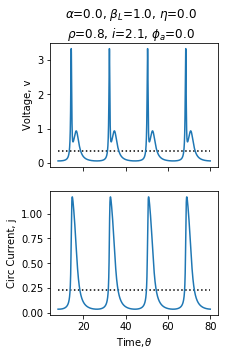

In [183]:
nStep = 8000
tau = .01
s = np.array([0.,0.])
par = np.array([0.,1.,0.,0.8,2.1,0.])

vj_timeseries(nStep,tau,s,par)

As a further example, below is Figure 5 from Tesche-Clarke developed manually

In [184]:
s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0])
D1 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0.25])
D2 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0.5])
D3 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0.8,1,0,0,2.1,0])
D4 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0.8,0,2.1,0])
D5 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0.8,2.1,0])
D6 = qSQUID(80000,.001,s,par)

Below is a plotting routine meant to present the results of our simulation in a similar manner to Figure 5 in Tesche-Clarke for comparison.

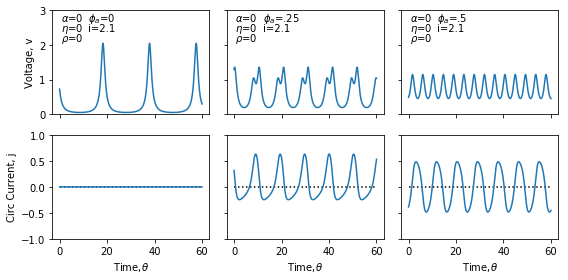

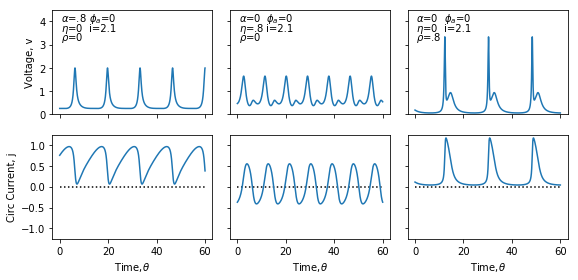

In [185]:
fig, ax = plt.subplots(2,3,figsize=(8,4))
ax1 = plt.subplot(2,3,1)
ax1.plot(D1[0,20000:]-20,D1[6,20000:])
ax1.text(.5,2.7,r"$\alpha$=0"); ax1.text(.5,2.4,r"$\eta$=0"); ax1.text(.5,2.1,r"$\rho$=0")
ax1.text(12,2.7,r"$\phi_a$=0"); ax1.text(12,2.4,r"i=2.1")
ax1.set(ylabel="Voltage, v",
       ylim=[0,3],
       xticklabels=([]))
ax2 = plt.subplot(2,3,2)
ax2.plot(D2[0,20000:]-20,D2[6,20000:])
ax2.text(.5,2.7,r"$\alpha$=0"); ax2.text(.5,2.4,r"$\eta$=0"); ax2.text(.5,2.1,r"$\rho$=0")
ax2.text(12,2.7,r"$\phi_a$=.25"); ax2.text(12,2.4,r"i=2.1")
ax2.set(ylim=[0,3],
       xticklabels=([]),
       yticklabels=([]))
ax3 = plt.subplot(2,3,3)
ax3.plot(D3[0,20000:]-20,D3[6,20000:])
ax3.text(.5,2.7,r"$\alpha$=0"); ax3.text(.5,2.4,r"$\eta$=0"); ax3.text(.5,2.1,r"$\rho$=0")
ax3.text(12,2.7,r"$\phi_a$=.5"); ax3.text(12,2.4,r"i=2.1")
ax3.set(ylim=[0,3],
       xticklabels=([]),
       yticklabels=([]))
ax4 = plt.subplot(2,3,4)
ax4.plot(D1[0,20000:]-20,D1[3,20000:])
ax4.hlines(0,0,60,linestyle='dotted')
ax4.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$",
       ylim=[-1,1])
ax5 = plt.subplot(2,3,5)
ax5.plot(D2[0,20000:]-20,D2[3,20000:])
ax5.hlines(0,0,60,linestyle='dotted')
ax5.set(ylim=[-1,1],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))
ax6 = plt.subplot(2,3,6)
ax6.plot(D3[0,20000:]-20,D3[3,20000:])
ax6.hlines(0,0,60,linestyle='dotted')
ax6.set(ylim=[-1,1],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))

fig.tight_layout()

fig, ax = plt.subplots(2,3,figsize=(8,4))
ax1 = plt.subplot(2,3,1)
ax1.plot(D4[0,20000:]-20,D4[6,20000:])
ax1.text(.5,4,r"$\alpha$=.8"); ax1.text(.5,3.6,r"$\eta$=0"); ax1.text(.5,3.2,r"$\rho$=0")
ax1.text(12,4,r"$\phi_a$=0"); ax1.text(12,3.6,r"i=2.1")
ax1.set(ylabel="Voltage, v",
       ylim=[0,4.5],
       xticklabels=([]))
ax2 = plt.subplot(2,3,2)
ax2.plot(D5[0,20000:]-20,D5[6,20000:])
ax2.text(.5,4,r"$\alpha$=0"); ax2.text(.5,3.6,r"$\eta$=.8"); ax2.text(.5,3.2,r"$\rho$=0")
ax2.text(12,4,r"$\phi_a$=0"); ax2.text(12,3.6,r"i=2.1")
ax2.set(ylim=[0,4.5],
       xticklabels=([]),
       yticklabels=([]))
ax3 = plt.subplot(2,3,3)
ax3.plot(D6[0,20000:]-20,D6[6,20000:])
ax3.text(.5,4,r"$\alpha$=0"); ax3.text(.5,3.6,r"$\eta$=0"); ax3.text(.5,3.2,r"$\rho$=.8")
ax3.text(12,4,r"$\phi_a$=0"); ax3.text(12,3.6,r"i=2.1")
ax3.set(ylim=[0,4.5],
       xticklabels=([]),
       yticklabels=([]))
ax4 = plt.subplot(2,3,4)
ax4.plot(D4[0,20000:]-20,D4[3,20000:])
ax4.hlines(0,0,60,linestyle='dotted')
ax4.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$",
       ylim=[-1.25,1.25])
ax5 = plt.subplot(2,3,5)
ax5.plot(D5[0,20000:]-20,D5[3,20000:])
ax5.hlines(0,0,60,linestyle='dotted')
ax5.set(ylim=[-1.25,1.25],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))
ax6 = plt.subplot(2,3,6)
ax6.plot(D6[0,20000:]-20,D6[3,20000:])
ax6.hlines(0,0,60,linestyle='dotted')
ax6.set(ylim=[-1.25,1.25],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))

fig.tight_layout()

#### Figure 6(a) from Tesche-Clarke:

Figure 6 in Tesche-Clarke presents the results of a simulation of a voltage sweep on the SQUID, bias current $i_{bias}$ vs. average voltage $\bar{v}$. The average voltage is treated as an input parameter, and bias current is presented as an output response.

In order to create this data, we need to instead sweep bias current as the input and observe the response in the average voltage. Further, to sweep bias current, we must perform a time series simulation at a regular partioning of a range of bias current inputs. We then calculate the average voltage for each of these time series and finally plot our findings as input vs response, or $i_{bias}$ vs. $\bar{v}$, as in Tesche-Clarke.

In [9]:
def iv_curve(nStep,tau,s,par,alpha=0,beta_L=0,eta=0,rho=0,phia=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta_L, eta, rho, i, phia]
        input parameter LIST - alpha, beta, eta, rho, phia
            multiple values of input parameter as list
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input list here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create currents to sweep
    i = np.arange(0.,6.,.1)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(i)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,6])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))
        meta1 = ['# beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phi_a=%s'%par[5]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],0.,par[5]])
        ch = ch + 1
    if beta_L != 0:
        beta_L = np.array(beta_L)
        k = len(beta_L)
        parj = np.zeros([k,6])
        la = r'$\beta_L$'; lc = 'beta_L'
        lb = np.copy(beta_L)
        ti = r'$\alpha$=%s, $\eta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))
        meta1 = ['# alpha=%s'%par[0],'eta_L=%s'%par[2],'rho=%s'%par[3],'phi_a=%s'%par[5]]
        for j in range(k):
            parj[j,:] = np.array([par[0],beta[j],par[2],par[3],0.,par[5]])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,6])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[5],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'rho=%s'%par[3],'phi_a=%s'%par[5]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],0.,par[5]])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,6])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[5],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'phi_a=%s'%par[5]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],0.,par[5]])
        ch = ch + 1
    if phia != 0:
        phia = np.array(phia)
        k = len(phia)
        parj = np.zeros([k,6])
        la = r'$\phi_a$'; lc = 'phi_a'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,phia[j]])
        ch = ch + 1
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,6])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phi_a=%s'%par[5]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(i)])
    else:
        V = np.zeros([2,len(i)])
        
    # cp - check progress, total outputs in V
    cp = k*len(i)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(i)):
            parjj[4] = i[m]
            S = qSQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(i))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(i),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(V[0],i)
        header = ['i','V']
    # k contours
    else:
        header = ['i']*(k+1)
        for j in range(k):
            ax.plot(V[j],i,label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    # ic = 0 line for comparison
    ax.plot(np.arange(0,2.6,.1),np.arange(0,5.2,.2),'--',
       label=r"$i_c=0$")
    ax.set(title=ti,
       xlabel=r"Average voltage, $\bar{v}$",
       ylabel="Bias current, i",
       xlim=[0,2.5],ylim=[0,6.])
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='IV'+timeti+'.csv'
    pngtitle='IV'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

#### Instructions for building IV contours

The function **iv_curve()** gives a singular or multiple contours of the transfer function as IV curves, bias current vs average voltage. This is similar to what we might see with the oscilloscope a physical SQUID.

To run the script, we need to supply the physical parameters and simulation prameters. This is done as below, by manually specifying each by defining a value or array.

The simulation parameters nStep and tau are supplied as an integer and a float respectively. As a practical matter, I have found **nStep**=80000 gives fine detail by averaging values over a long time series run, but these simulations can take several minutes to complete. A value of **nStep**=8000 gives fine enough detail to see representative behavior without taking as long to complete the simulation. To capture high frequency detail in the time series, I would recommend using **tau**=0.01. To run fast simulations to see where you are at, I recommend **tau**=0.1.

The initial state of the system is defined by the input **s**, an array of floats defining the initial phase differences at each junction. These initial phase values are somewhat arbitrary as the system will settle into a regular periodic behavior. Any average values used in the script have the first 10% of the time series removed to mitigate any transient response before this regular periodic behavior emerges.

To create contours, some parameter other than input current must be swept. The desired parameter to sweep is chosen by using its name to define a **LIST** of float values to sweep for that parameter. This input must be given in the form of a list. This parameter list will replace whatever value is given in the parameter array **par** described below. The appropriate names are **alpha**, **beta_L**, **eta**, **rho** and **phia**. Use around three values max as the processor time goes directly as the length of this list. **IF no array valued parameter is defined** the routine will use the value given in the parameter array **par** described below, and only one contour curve will be drawn.

The parameter array **par** is a float array describing **alpha**, **beta_L**, **eta**, **rho**, **i**, and **phia** in that order. **NOTE**, the parameter **i** is redundant but a placeholder value must be in the parameter array anyway. The routine will sweep i automatically, from 0 to 6. As noted above, any parameter given as it's own list will overwrite the value given here, but a dummy value must be supplied here.

#### IV curve example

Imediately below is an example IV curve generation.

Assign a variable **nStep** an integer value. (start with 8000 to 80000)

Assign a varialbe **tau** a float value. (start with 0.01 to 0.1)

Assign a list of contour values. In this case, we want to sweep applied flux. We name a list **Phia** in this case. (Use somethig other than the routine's name for the parameter here, hence capitol **Phia**)

Assign a variable **par** an array of float values representing the parameters desired. In this case, **alpha**=0, **beta_L**=1, **eta*=0, **rho**=0, a placeholder 0 for **i**, and a placeholder 0.5 for **phia**.

Call the routine, **iv_curve(nStep,tau,s,par,phia=Phia)** to generate contours. A plot will be generated and saved to the parent directory, as well as a csv file.

Note that one could call the routine without explictly defining the parameters ahead of time by typing **iv_curve(8000,.01,np.array([1.,0.]),np.array([0.,1.,0.,0.,0.,0.5]),phia=[0.,.25,.5])** with the same result.


Progress: [####################] 100.0%
csv file written out: IV20191117025436.csv
png file written out: IV20191117025436.png


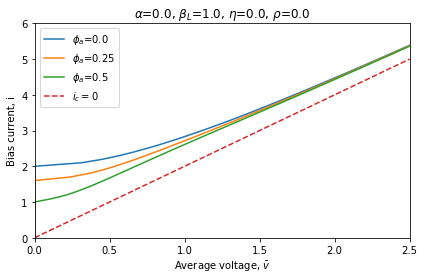

In [179]:
nStep = 80000
tau = .01
s = np.array([1.,0.])
Phia = [0.,.25,.5]
par = np.array([0.,1.,0.,0.,0.,0.5])

iv_curve(nStep,tau,s,par,phia=Phia)

As a further example, below is a manual development of a set of IV curves to plot as countours.

In [128]:
# build data for bias current v average voltage
# Run time series voltage, take time average
# store output as array vbar v ibias

nStep = 80000
tau = .01
i = np.arange(2.,6.,.1)
F61 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0.,0.])
    par = np.array([0.,1.,0.,0.,i[k],0.])
    S = qSQUID(nStep,tau,s,par)
    F61[0,k] = sum(S[6,])/len(S[6,])
    F61[1,k] = i[k]
    update_progress(k/int(len(i)))
update_progress(1)

Progress: [####################] 100.0%


In [133]:
i = np.arange(1.5,6.,.1)
F62 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,i[k],0.25])
    S = qSQUID(nStep,tau,s,par)
    F62[0,k] = sum(S[6,])/len(S[6,])
    F62[1,k] = i[k]
    update_progress(k/int(len(i)))
update_progress(1)

Progress: [####################] 100.0%


In [134]:
i = np.arange(1.,6.,.1)
F63 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,i[k],0.5])
    S = qSQUID(nStep,tau,s,par)
    F63[0,k] = sum(S[6,])/len(S[6,])
    F63[1,k] = i[k]
    update_progress(k/int(len(i)))
update_progress(1)

Progress: [####################] 100.0%


Below is a plotting routine meant to present the results of our simulation in a similar manner to Figure 6(a) in Tesche-Clarke for comparison.

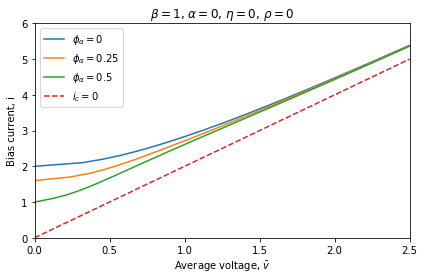

In [180]:
fig,ax = plt.subplots()
ax.plot(F61[0,],F61[1,],label=r"$\phi_{\alpha}=0$")
ax.plot(F62[0,],F62[1,],label=r"$\phi_{\alpha}=0.25$")
ax.plot(F63[0,],F63[1,],label=r"$\phi_{\alpha}=0.5$")
ax.plot(np.arange(0,2.6,.1),np.arange(0,5.2,.2),'--',
       label=r"$i_c=0$")
ax.set(title=r"$\beta=1$, $\alpha=0$, $\eta=0$, $\rho=0$",
       xlabel=r"Average voltage, $\bar{v}$",
       ylabel="Bias current, i",
       xlim=[0,2.5],ylim=[0,6.])
ax.legend()
fig.tight_layout()

#### Figure 7 from Tesche-Clarke:

Figure 7 presents average voltage $\bar{v}$ as a response to applied flux, $\phi_a$, and average circulating current $\bar{j}$ as a response to applied flux for the same input parameters.

The bias current $i_{bias}$ is set to 2.1. The parameters $\alpha$, $\eta$, and $\rho$ are set to zero. We sweep applied flux from 0 to 1.

Each curve is built, similarly to Figure 6, by completing a time series simulation for each value of a regular partition of the range of applied flux desired. Then the responses of interest are averaged for each time series and presented as the response.

In [10]:
def vphi_curve(nStep,tau,s,par,alpha=0,beta_L=0,eta=0,rho=0,i=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta, eta, rho, i, phia]
        input parameter array - alpha, beta, eta, rho, phia
            multiple values of input parameter as array
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input array here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create fluxes to sweep
    phia = np.arange(0.,1.1,.1)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(phia)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,6])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\i$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[4],3)))
        meta1 = ['# beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],par[4],0.])
        ch = ch + 1
    if beta_L != 0:
        beta_L = np.array(beta_L)
        k = len(beta_L)
        parj = np.zeros([k,6])
        la = r'$\beta_L$'; lc = 'beta_L'
        lb = np.copy(beta_L)
        ti = r'$\alpha$=%s, $\eta$=%s, $\rho$=%s, $\i$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[4],3)))
        meta1 = ['# alpha=%s'%par[0],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4]]
        for j in range(k):
            parj[j,:] = np.array([par[0],beta_L[j],par[2],par[3],par[4],0.])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,6])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\i$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[4],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'rho=%s'%par[3],'i=%s'%par[4]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],par[4],0.])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,6])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\i$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[4],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'i=%s'%par[4]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],par[4],0.])
        ch = ch + 1
    if i != 0:
        i = np.array(i)
        k = len(phia)
        parj = np.zeros([k,6])
        la = r'$i$'; lc = 'i'
        lb = np.copy(i)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],i[j],0.])
        ch = ch + 1
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,6])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $i$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[4],3)))
        meta1 = ['# alpha=%s'%par[0],'beta_L=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(phia)])
    else:
        V = np.zeros([2,len(phia)])
        
    # cp - check progress, total outputs in V
    cp = k*len(phia)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(phia)):
            parjj[5] = phia[m]
            S = qSQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(phia))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(phia),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(phia,V[0])
        header = ['phia','V']
    # k contours
    else:
        header = ['phia']*(k+1)
        for j in range(k):
            ax.plot(phia,V[j],label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    ax.set(title=ti,
       xlabel=r'Applied flux, $\phi_a$',
       ylabel=r"Average voltage, $\bar{v}$")
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='VPhi'+timeti+'.csv'
    pngtitle='VPhi'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

#### Instructions for building V Phi contours

The function **vphi_curve()** gives a singular or multiple contours of the transfer function as V Phi curves, average voltage vs applied flux. This is similar to what we might see with the oscilloscope a physical SQUID.

To run the script, we need to supply the physical parameters and simulation prameters. This is done as below, by manually specifying each by defining a value or array.

The simulation parameters **nStep** and **tau** are supplied as an integer and a float respectively. As a practical matter, I have found **nStep**=80000 gives fine detail by averaging values over a long time series run, but these simulations can take several minutes to complete. A value of **nStep**=8000 gives fine enough detail to see representative behavior without taking as long to complete the simulation. To capture high frequency detail in the time series, I would recommend using **tau**=0.01. To run fast simulations to see where you are at, I recommend **tau**=0.1.

The initial state of the system is defined by the input **s**, an array of floats defining the initial phase differences at each junction. These initial phase values are somewhat arbitrary as the system will settle into a regular periodic behavior. Any average values used in the script have the first 10% of the time series removed to mitigate any transient response before this regular periodic behavior emerges.

To create contours, some parameter other than input current must be swept. The desired parameter to sweep is chosen by using its name to define a **LIST** of float values to sweep for that parameter. This input must be given in the form of a list. This parameter list will replace whatever value is given in the parameter array **par** described below. The appropriate names are **alpha**, **beta_L**, **eta**, **rho** and **phia**. Use around three values max as the processor time goes directly as the length of this list. **IF no array valued parameter is defined** the routine will use the value given in the parameter array **par** described below, and only one contour curve will be drawn.

The parameter array **par** is a float array describing **alpha**, **beta_L**, **eta**, **rho**, **i**, and **phia** in that order. **NOTE**, the parameter **phia** is redundant but a placeholder value must be in the parameter array anyway. The routine will sweep **phia** automatically, from 0 to 1. As noted above, any parameter given as it's own list will overwrite the value given here, but a dummy value must be supplied here.

#### V Phi curve example

Imediately below is an example V PHi curve generation.

Assign a variable **nStep** an integer value. (start with 8000 to 80000)

Assign a varialbe **tau** a float value. (start with 0.01 to 0.1)

Assign a list of contour values. In this case, we want to sweep the inductance parameter **beta_L**. We name a list **Beta** in this case. (Use somethig other than the routine's name for the parameter here, hence capitol **Beta**)

Assign a variable **par** an array of float values representing the parameters desired. In this case, **alpha**=0, a placeholder 0 for **beta_L**, **eta*=0, **rho**=0, **i**=2.1, and a placeholder 0.5 for **phia**.

Call the routine, **iv_curve(nStep,tau,s,par,beta_L=Beta)** to generate contours. A plot will be generated and saved to the parent directory, as well as a csv file.

Note that one could call the routine without explictly defining the parameters ahead of time by typing **iv_curve(80000,.01,np.array([1.,0.]),np.array([0.,1.,0.,0.,2.1,0.5]),beta_L=[.4,1.,2.,4.])** with the same result.

Progress: [####################] 100.0%
csv file written out: VPhi20191117022951.csv
png file written out: VPhi20191117022951.png


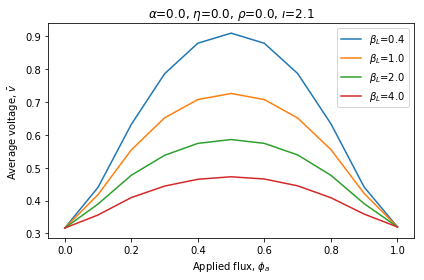

In [175]:
nStep = 8000
tau = .1
s = np.array([1.,0.])
Beta = [.4,1.,2.,4.]
par = np.array([0.,0.,0,0,2.1,0.5])

vphi_curve(nStep,tau,s,par,beta_L=Beta)

As a further example, we can develop a V Phi curve manually as below. In this case we also average and store the circulating current to plot.

In [176]:
# loop over applied fluxes to build
# vbar vx phi_a 'contor' plot

# for beta = 0.4

## need to make this a function that can be called
## from a gui

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)                # create input array
F71 = np.zeros([3,len(phia)])               # create ouput array
for k in range(len(phia)):                  # loop over phia s
    s = np.array([0,0])                     # set initial state vector to zero
    par = np.array([0,0.4,0,0,2.1,phia[k]]) # set parameter vector
    S = qSQUID(nStep,tau,s,par)             # run the sim
    F71[0,k] = phia[k]                      # enter phia s to output array
    F71[1,k] = sum(S[6,])/len(S[6,])        # store average voltage
    F71[2,k] = sum(S[3,])/len(S[3,])        # store average current

In [177]:
# as above,

# beta = 1

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F72 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F72[0,k] = phia[k]
    F72[1,k] = sum(S[6,])/len(S[6,])
    F72[2,k] = sum(S[3,])/len(S[3,])
    update_progress(k/len(phia))
update_progress(1)

Progress: [####################] 100.0%


In [178]:
# as above,

# beta = 2

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F73 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,2,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F73[0,k] = phia[k]
    F73[1,k] = sum(S[6,])/len(S[6,])
    F73[2,k] = sum(S[3,])/len(S[3,])
    update_progress(k/len(phia))
update_progress(1)

Progress: [####################] 100.0%


In [150]:
# as above,

# beta = 4

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F74 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,4,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F74[0,k] = phia[k]
    F74[1,k] = sum(S[6,])/len(S[6,])
    F74[2,k] = sum(S[3,])/len(S[3,])
    update_progress(k/len(phia))
update_progress(1)

Progress: [####################] 100.0%


Below is the plotting routine that present our data in a similar fasion to Tesche-Clarke for comparison.

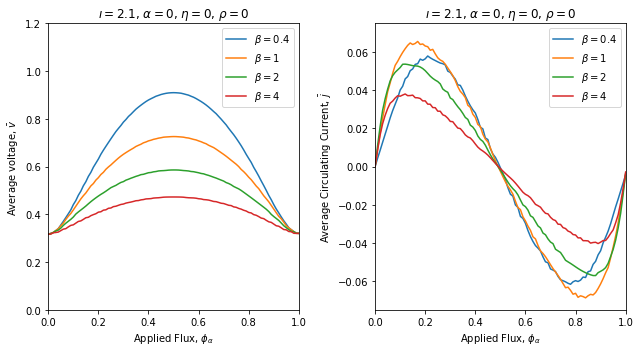

In [151]:
fig,ax = plt.subplots(1,2,figsize=[9,5])
ax1 = plt.subplot(1,2,1)
ax1.plot(F71[0,],F71[1,],label=r"$\beta=0.4$")
ax1.plot(F72[0,],F72[1,],label=r"$\beta=1$")
ax1.plot(F73[0,],F73[1,],label=r"$\beta=2$")
ax1.plot(F74[0,],F74[1,],label=r"$\beta=4$")
ax1.set(title=r"$\i=2.1$, $\alpha=0$, $\eta=0$, $\rho=0$",
      xlabel=r"Applied Flux, $\phi_{\alpha}$",
      ylabel=r"Average voltage, $\bar{v}$",
      ylim=[0,1.2],xlim=[0,1.])
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(F71[0,],F71[2,],label=r"$\beta=0.4$")
ax2.plot(F72[0,],F72[2,],label=r"$\beta=1$")
ax2.plot(F73[0,],F73[2,],label=r"$\beta=2$")
ax2.plot(F74[0,],F74[2,],label=r"$\beta=4$")
ax2.set(title=r"$\i=2.1$, $\alpha=0$, $\eta=0$, $\rho=0$",
      xlabel=r"Applied Flux, $\phi_{\alpha}$",
      ylabel=r"Average Circulating Current, $\bar{j}$",
      ylim=[-.075,.075],xlim=[0,1.])
ax2.legend()

fig.tight_layout()

In [18]:
def transfer_fn(nStep,tau,s,par,i,phia):
    m = len(i)
    n = len(phia)
    l = int(nStep*.1)
    N = m*n
    vp = np.zeros([n,m])
    iv = np.zeros([m,n])
    
    # calculate average voltage surface
    for j in range(0,m):
        for k in range(0,n):
            par[4] = i[j]
            par[5] = phia[k]
            X = qSQUID(nStep,tau,s,par)
            v = np.average(X[6,l:])
            vp[k,j] = v
            iv[j,k] = v
            update_progress((j*n+k)/(m*n))
    update_progress(1)
    
    ## smooth and interpolate over a grid lx dense ##
    l = 1
    inew = np.copy(i)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
    phianew = np.copy(phia)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

    x, y = np.meshgrid(phia,i)
    xnew, ynew = np.meshgrid(phianew,inew)
    z = np.copy(iv)
    tck = interpolate.bisplrep(y, x, iv, s=.05) # s = smoothing
    ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
    
    # find gradient of surface
    dv = np.gradient(ivi,inew,phianew)
    
    # filename stuff
    # build rest of metadata needed for csv
    meta1 = ['# alpha=%s, betaL=%s, eta=%s, rho=%s' %(par[0],par[1],par[2],par[3])]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    meta3 = ['# values shown are vbar, representing a surface in dimensions i (vertical) and phia (horizontal)']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='AveVsurface'+timeti+'.csv'
    pngtitle='AveVsurface'+timeti+'.png'
    
    # create, write, and save(close) average voltage surface csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(iv)
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot average voltage surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(i)
    y = np.copy(phia)
    x, y = np.meshgrid(y, x)
    z = np.copy(iv)
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'average voltage $\bar{v}$',
          title = r'$\bar{v}(i,\phi_a)$; $\alpha$=%s, $\beta_L$=%s, $\eta$=%s,$\rho$=%s' %(par[0],par[1],par[2],par[3]))
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    
    # modify file stuff to ouput transfer function surface
    meta3 = ['# values shown are dvbar/dphia, the transfer function in dimensions i (vertical) and phia (horizontal)']
    csvtitle='TransferFn'+timeti+'.csv'
    pngtitle='TransferFn'+timeti+'.png'
    
    # create, write, and save(close) transger function csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(dv[1])
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot transfer function
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(inew)
    y = np.copy(phianew)
    x, y = np.meshgrid(y, x)
    z = np.copy(dv[1]) # partial dvbar/dphia
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
          title = r'$\bar{v}(i,\phi_a)$; $\alpha$=%s, $\beta_L$=%s, $\eta$=%s,$\rho$=%s' %(par[0],par[1],par[2],par[3]))
    ax.view_init(65,-60)
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    return(iv)

In [21]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 8000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
betaL = 1.
eta = 0.
rho = 0.
i = np.arange(-3.,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(-1.,1.1,.1)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)
par = np.array([alpha,betaL,eta,rho,0.,0.])

Progress: [####################] 100.0%
csv file written out: AveVsurface20191130015415.csv
png file written out: AveVsurface20191130015415.png
csv file written out: TransferFn20191130015415.csv


C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=3,3 nx,ny=28,28 m=1281 fp=427.912149 s=0.050000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


png file written out: TransferFn20191130015415.png


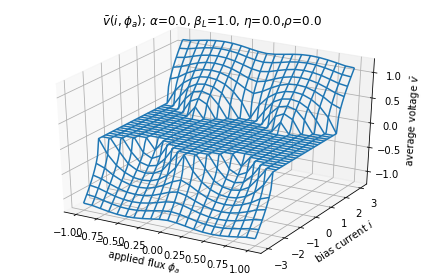

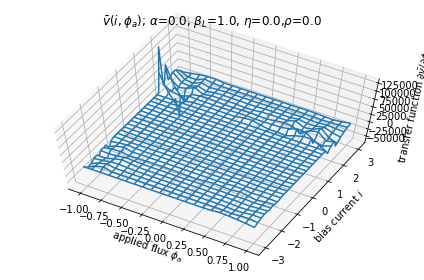

In [22]:
Vsurf = transfer_fn(nStep,tau,s,par,i,phia)

### Conclusion

This model appears to perform adequately. The results it generates are in agreement with the results presented in Tesche-Clarke section 3.2. This model will be used as the foundation to build a model including Johnson noise, and a second order model with noise.